In [7]:
import os
import librosa
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

In [2]:
def load_segmented_files(directory):
    wav_files = []
    for file in tqdm(os.listdir(directory)):
        if file.endswith(".wav"):
            file_path = os.path.join(directory, file)
            y, sr = librosa.load(file_path, sr=None)
            wav_files.append((y, sr))
    return wav_files

In [3]:
# 指定 STFT 參數
n_fft = 2048
hop_length = 512
# 指定 
n_mels = 128
mel_spectrograms = []
# 讀取分割後的音訊片段
segmented_files = load_segmented_files('segmented_datasets')

100%|██████████| 12430/12430 [00:40<00:00, 307.11it/s]


In [4]:
target_sample_rate = 16000 
def convert_to_mel_spectrogram(audio, n_fft, hop_length, n_mels):
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=target_sample_rate, n_fft=n_fft, hop_length=hop_length,
                                                     n_mels=n_mels)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db

for audio, _ in tqdm(segmented_files):
    mel_spectrogram = convert_to_mel_spectrogram(audio, n_fft, hop_length, n_mels)
    mel_spectrograms.append(mel_spectrogram)

100%|██████████| 12430/12430 [00:43<00:00, 286.29it/s]


In [8]:
def plot_mel_spectrogram(mel_spectrogram):
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(mel_spectrogram, x_axis='time', y_axis='mel', sr=target_sample_rate, hop_length=hop_length)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.savefig('mel_spectrogram.png')
    plt.show()

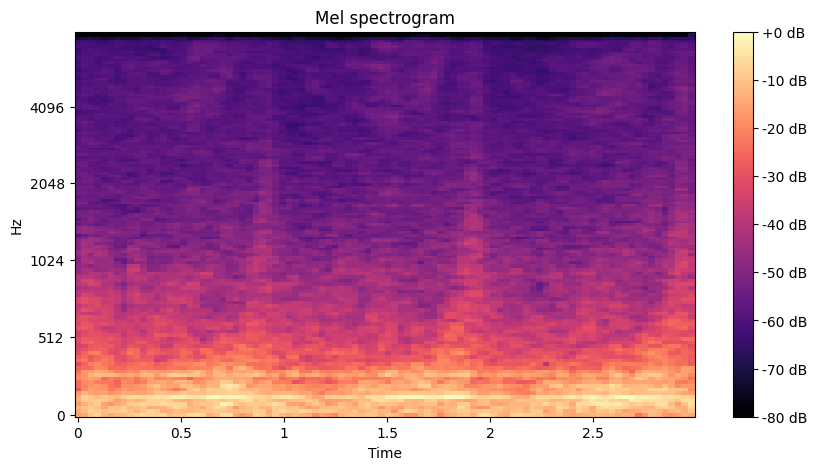

In [9]:
mel_spectrogram_index = 0
mel_spectrogram = mel_spectrograms[mel_spectrogram_index]
plot_mel_spectrogram(mel_spectrogram)

# Spilt Dataset to training and testing

In [ ]:
from sklearn.model_selection import train_test_split

# 將梅爾頻譜圖轉換為numpy數組
mel_spectrograms_array = np.array(mel_spectrograms)

# 對數據進行切分
train_data, test_data = train_test_split(mel_spectrograms_array, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

print("訓練集數據形狀:", train_data.shape)
print("驗證集數據形狀:", val_data.shape)
print("測試集數據形狀:", test_data.shape)